# apo05 Workflow Demo
this is the demo data we've used a lot... it's originally from SLH, used to teach APO observing class for years

use it to package the PyDIS->specreduce->kosmos functions into new files, easily import, etc....

THEN the goal will be to use this as an outline for some basic reduction wrappers!

In [2]:
 # need notebook backend for interaction
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u

# import kosmos... if we do it right this should be the only other thing to import somday!
import kosmos
kosmos.__version__

'0.01'

## 1. Bias

In [4]:
# to run on data, the user should provide lists of files to reduce.
# we can do this via the old IRAF way for now (b/c I'm old fashioned),
# but probably could design a more pythonic way (e.g. w/ glob or similar)

dir = 'kosmos/testdata/slh05_test/apo05/'
biasfiles_i = pd.read_table(dir + 'biaslist.txt', names=['impath'])
biasfiles = dir + biasfiles_i['impath'].values
biasfiles

array(['kosmos/testdata/slh05_test/apo05/05may31.0022r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0023r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0024r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0025r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0026r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0027r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0028r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0029r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0030r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0031r.fits'],
      dtype=object)

In [5]:
# use simple wrapper for median bias combining
bias = kosmos.biascombine(biasfiles) 
print(bias.shape)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(1078, 2098)


<IPython.core.display.Javascript object>


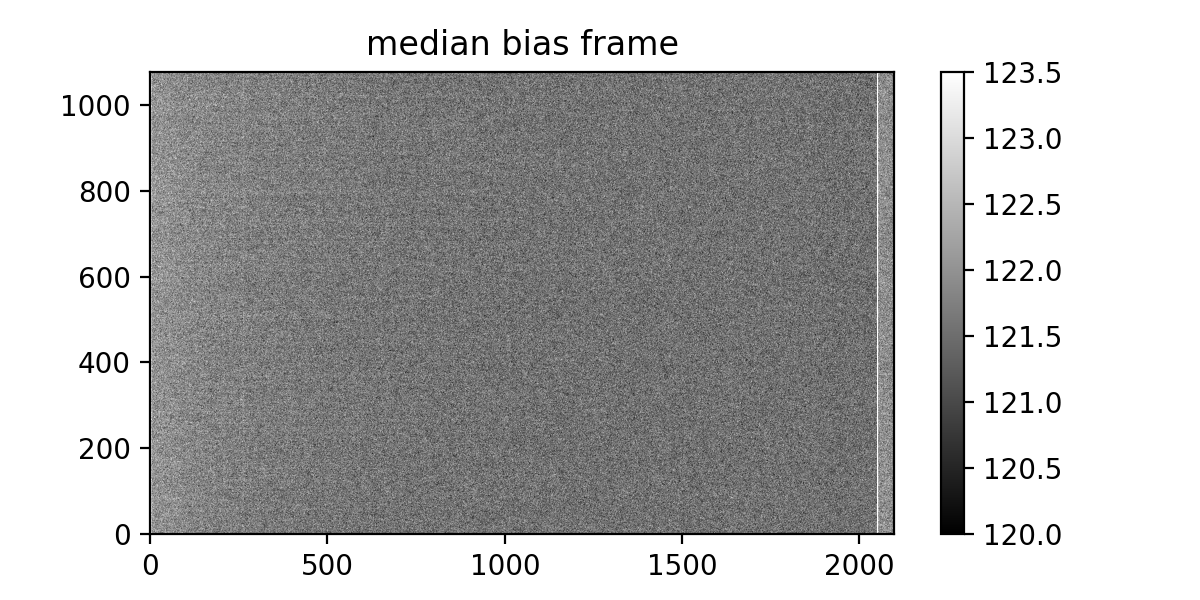

In [6]:
plt.figure(figsize=(6,3))
plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
plt.title('median bias frame')
plt.clim(np.percentile(bias, (5, 98)))
cb = plt.colorbar()

## 2. Flat

In [7]:
flatfiles_i = pd.read_table(dir + 'flatlist.txt', names=['impath'])
flatfiles = dir + flatfiles_i['impath'].values
flatfiles

array(['kosmos/testdata/slh05_test/apo05/05may31.0037r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0038r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0039r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0040r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0041r.fits'],
      dtype=object)

In [8]:
# a wrapper around Combiner, the spectral response normalization, and the illumination correction
# this should work WITH or WITHOUT a bias given
flat, ilum = kosmos.flatcombine(flatfiles, bias=bias)

print(ilum.shape) # this is the indicies that are illuminated
print(flat.shape)
print(flat.unit)

/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(748,)
(748, 2048)
adu / s


<IPython.core.display.Javascript object>


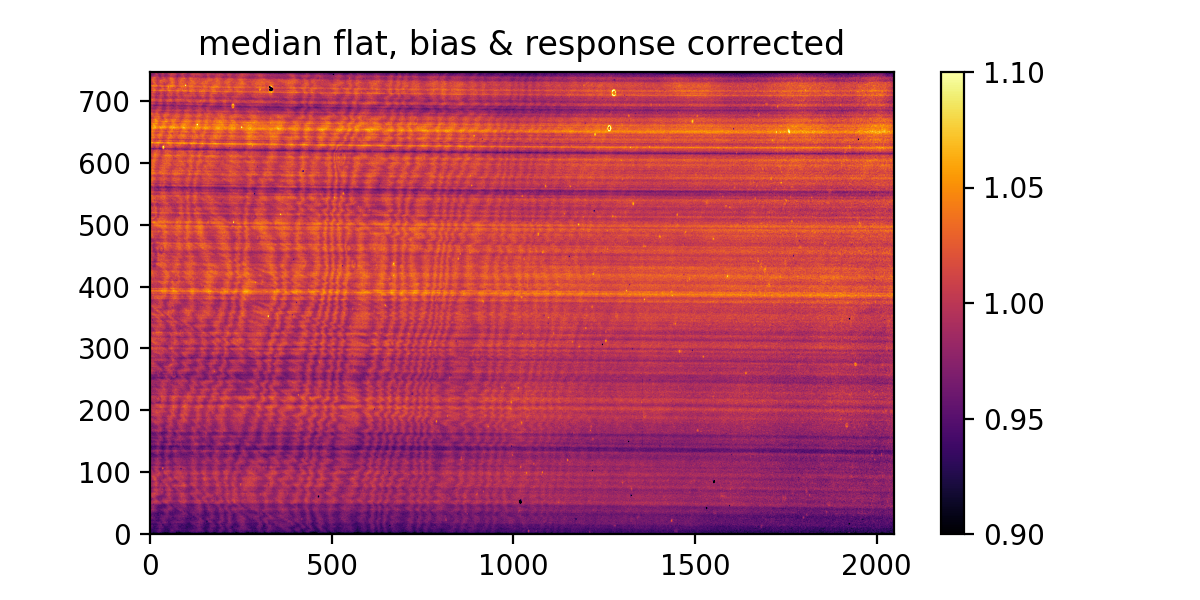

In [9]:
plt.figure(figsize=(6,3))
plt.imshow(flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(.9,1.1)
plt.title('median flat, bias & response corrected')
cb = plt.colorbar()

<IPython.core.display.Javascript object>


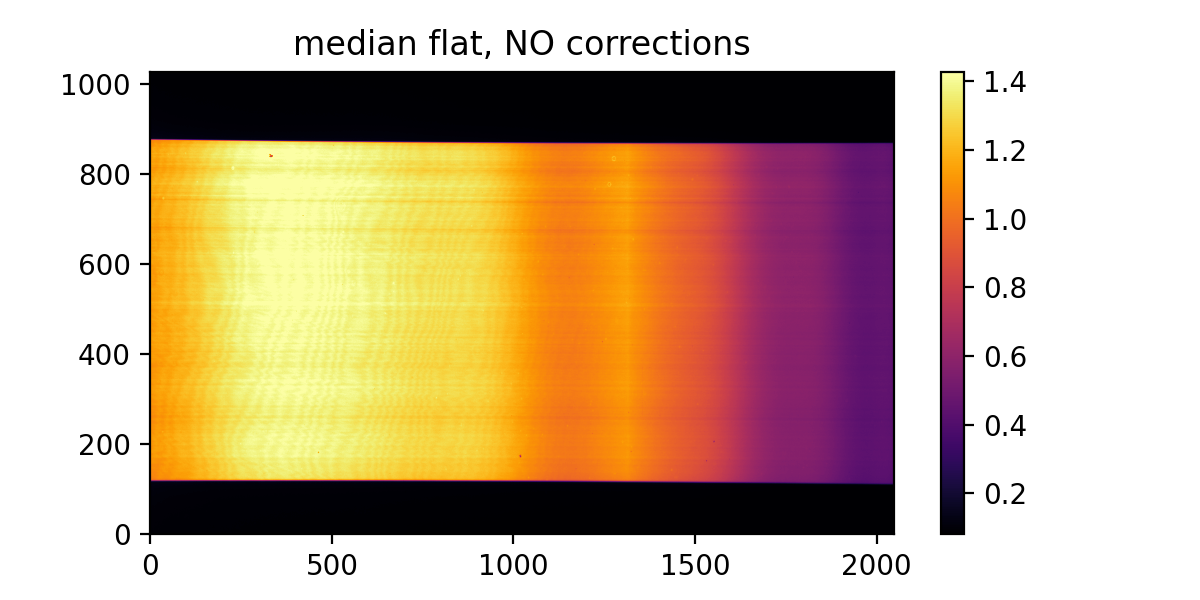

(1028, 2048)
adu / s


In [10]:
# if you turn off the illumination and response corrections, you just get a normalized median combined image
# i.e. could be used for photometry
medflat = kosmos.flatcombine(flatfiles, illumcor=False, responsecor=False)

plt.figure(figsize=(6,3))
plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(np.percentile(medflat, (5, 98)))
plt.title('median flat, NO corrections')
cb = plt.colorbar()

print(medflat.shape)
print(medflat.unit)

## 3. Processing Data
Functions to read a science frame, and "reduce" or process it with the standard calibrations from above (e.g. bias and flat)

In a pipeline you'd probably do part of this to all flux and wavelength calibration frames, and then loop over all science frames and apply ALL corrections to it... but we'll do this in the simplier order here

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(748, 2048)
adu / s


<IPython.core.display.Javascript object>


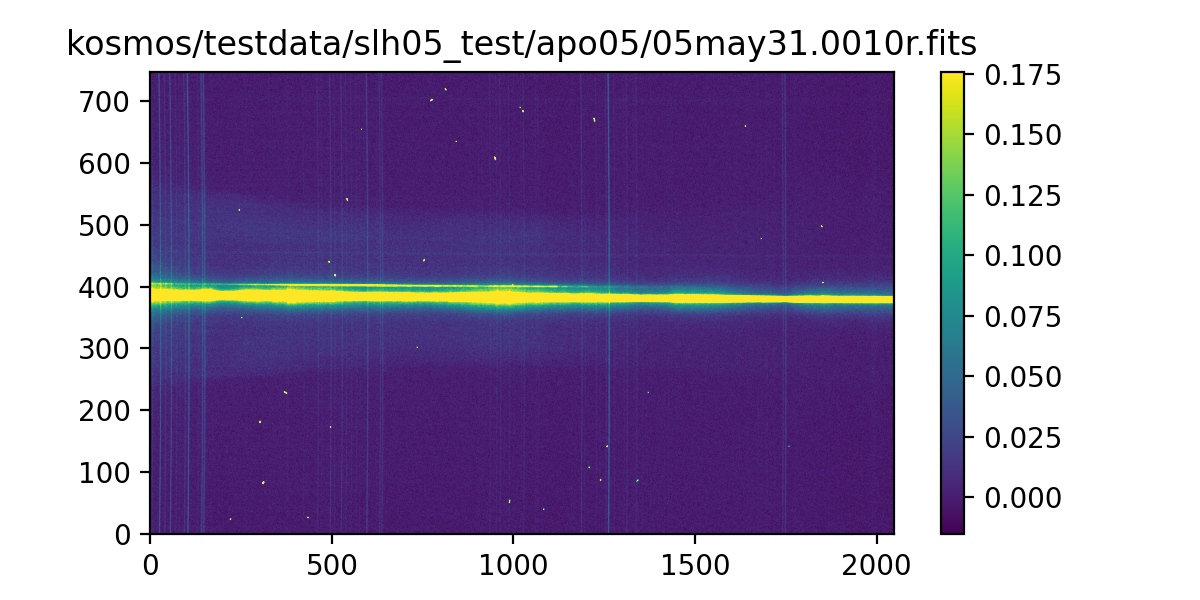

Text(0.5, 1.0, 'kosmos/testdata/slh05_test/apo05/05may31.0010r.fits')

In [11]:
# how to read in any science or calibration frame w/ a spectrum present

sci = dir + '05may31.0010r.fits'  # spectrum of the one target star, Gl 669A
sciimg = kosmos.proc(sci, bias=bias, ilum=ilum, flat=flat, trim=True)

print(sciimg.shape)
print(sciimg.unit)

plt.figure(figsize=(6,3))
plt.imshow(sciimg, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg, (5, 98)))
cb = plt.colorbar()
plt.title(sci)

(748, 2048)
adu / s


<IPython.core.display.Javascript object>


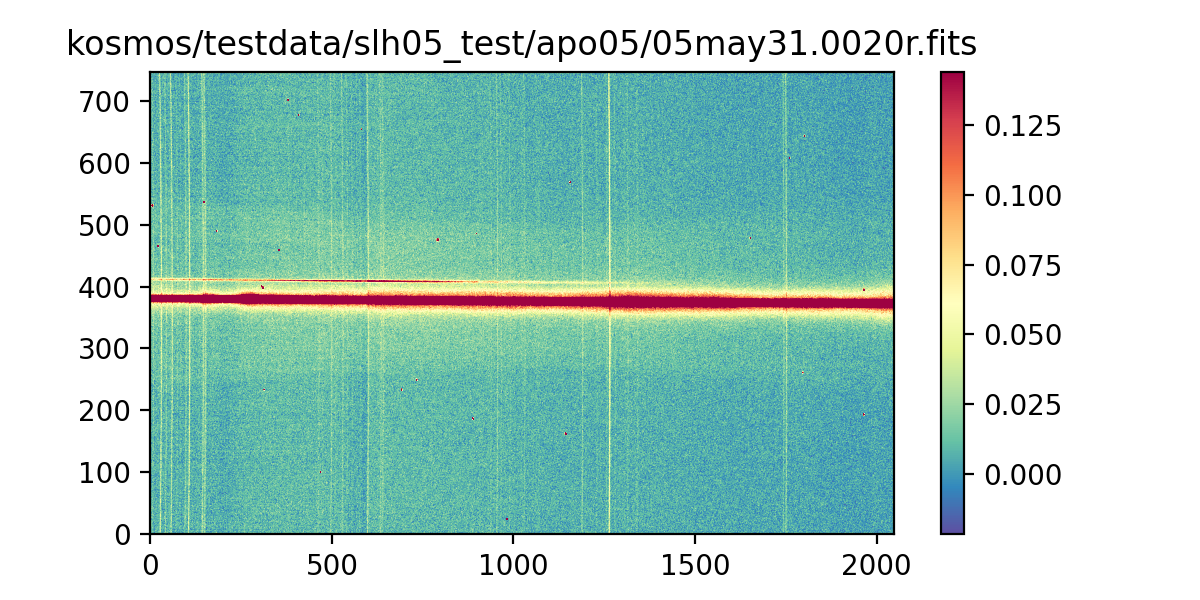

Text(0.5, 1.0, 'kosmos/testdata/slh05_test/apo05/05may31.0020r.fits')

In [12]:
fcal = dir + '05may31.0020r.fits' # Flux std star observation, BD+282411

calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=True)
print(sciimg.shape)
print(sciimg.unit)

plt.figure(figsize=(6,3))
plt.imshow(calimg, origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)
plt.clim(np.percentile(calimg, (5, 98)))
cb = plt.colorbar()
plt.title(fcal)

## 4. Trace & Extract

<IPython.core.display.Javascript object>


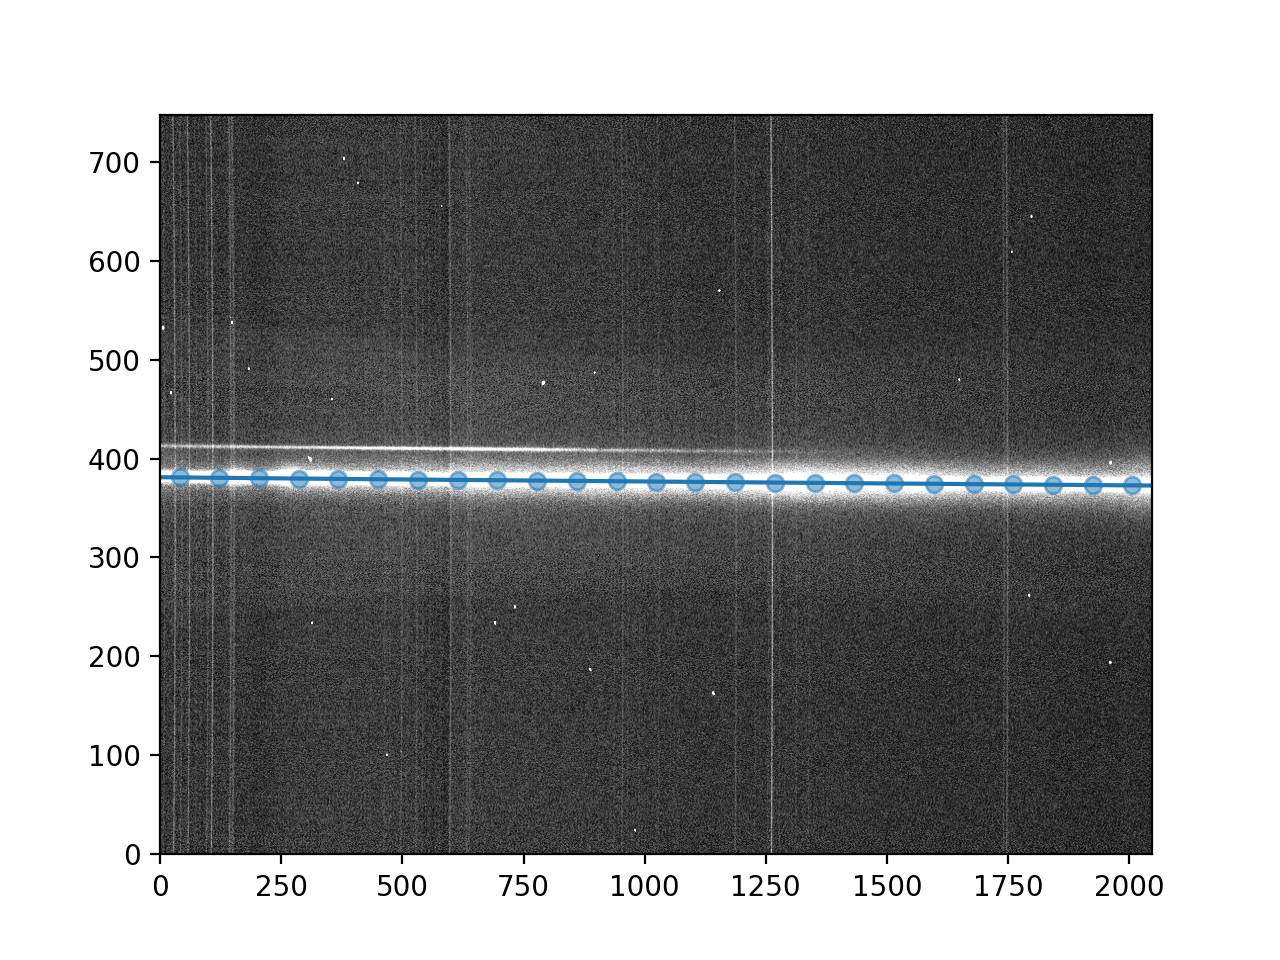

/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(2048,)

In [13]:
cal_trace = kosmos.trace(calimg, display=True, nbins=25)
sci_trace = kosmos.trace(sciimg, display=False, nbins=55)

sci_trace.shape

<IPython.core.display.Javascript object>


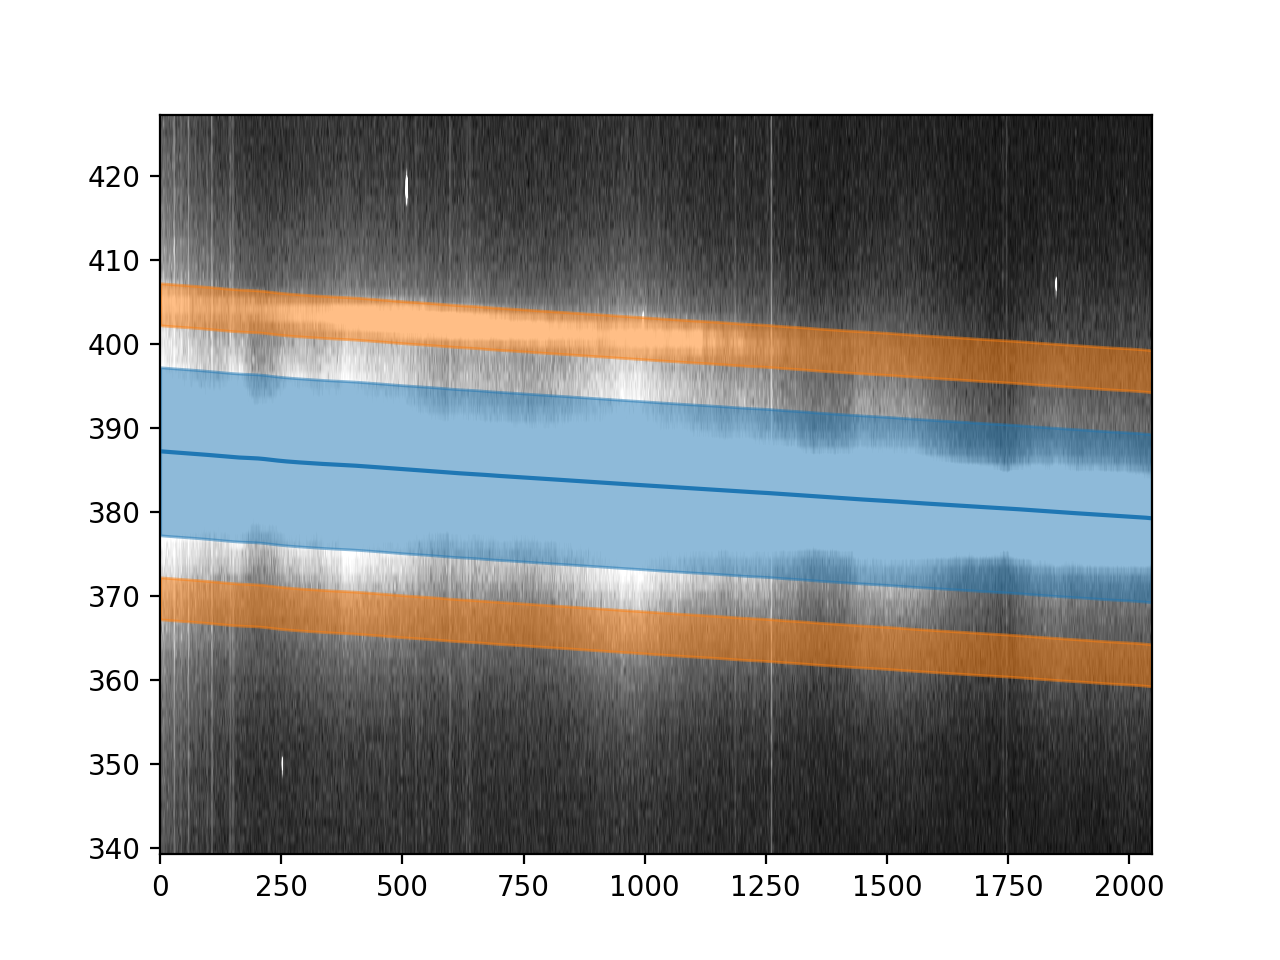

In [14]:
sci_ex, sci_sky = kosmos.BoxcarExtract(sciimg, sci_trace, display=True, apwidth=10, skysep=5, skywidth=5)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=False, apwidth=10, skysep=5, skywidth=5)

<IPython.core.display.Javascript object>


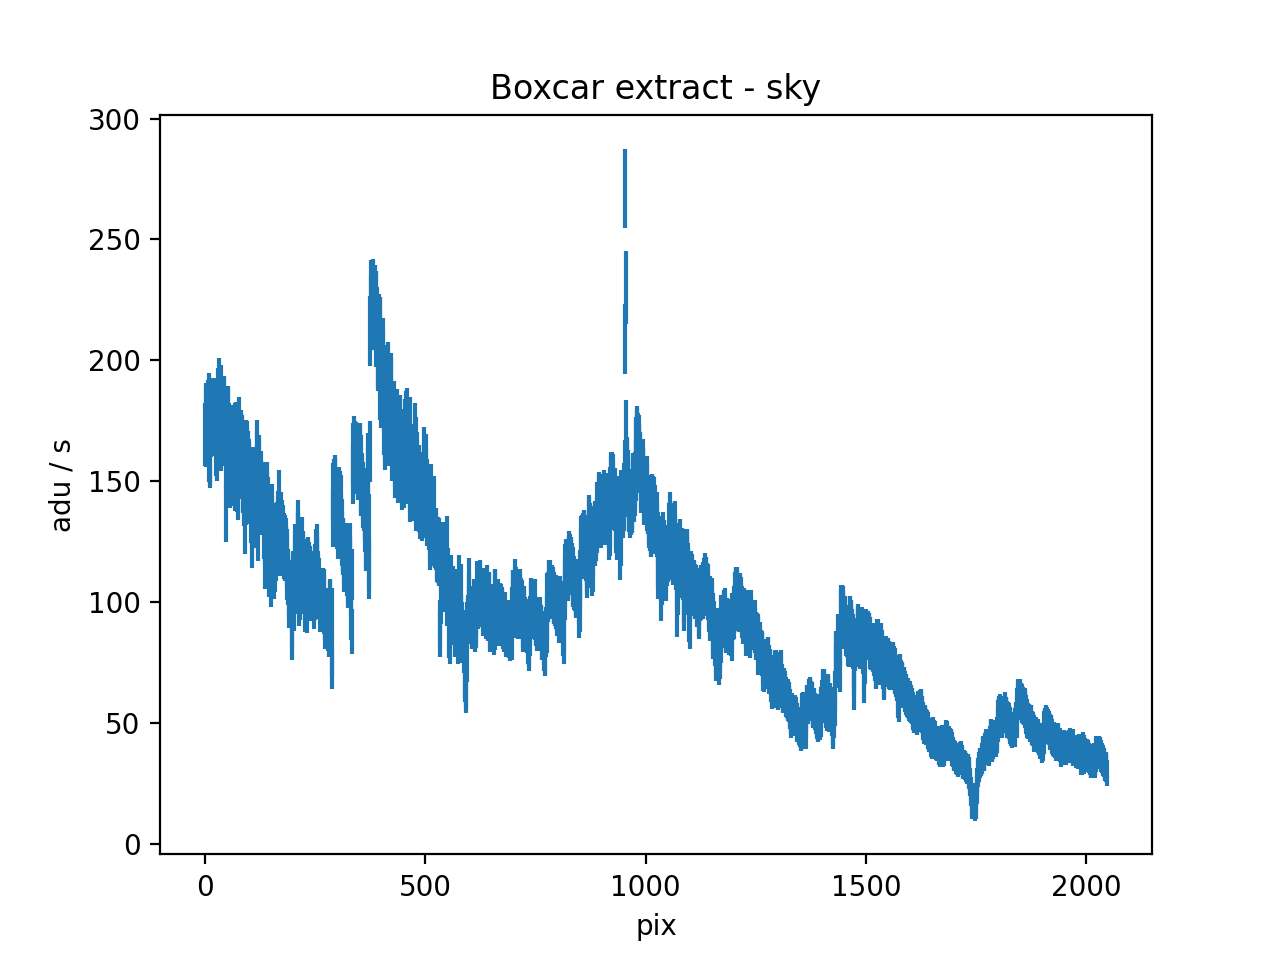

Text(0.5, 1.0, 'Boxcar extract - sky')

In [16]:
plt.errorbar(sci_ex.spectral_axis.value, sci_ex.flux.value - sci_sky.flux.value, 
             yerr=sci_ex.uncertainty.array, linestyle='none')
plt.xlabel(sci_ex.spectral_axis.unit)
plt.ylabel(sci_ex.flux.unit)
plt.title('Boxcar extract - sky')

# plt.plot(sci_sky.spectral_axis.value, sci_sky.flux.value)


## 5. Wavelength Calibration
This is (in my opinion) the hardest part of the entire pipeline.

There are opportunities to do things automatically, which are kinda tough for ANY arbitrary lamps/solutions, but very doable if we're focusing on a specific set of lamps or a single instrument whose behavior can be well profiled and saved.

Also it is tough to make a very slick GUI in python that works always, like IRAF/DS9 did... so lets focus for now only on a very restricted environment: notebooks

I think we should have the basic interactive mode implemented, and some very basic automated approaches, including:
- maybe use the simple PyDIS auto-identify code?
- skip the interactive identify if lines are previously known
- that's a precursor to having a base solution "model" that we can draw on in the future if (for example) no arclamps were taken


the high-level tasks involved in Identify are:
- processing the arclamp image (bias/flat), not super important, but worth doing
- taking a slice through the lamp image, just a cut in the middle is OK, or use actual science trace, both have merit
- finding peaks, could be manually, or automatically (from MANY approaches), or have a list already (previously done)
- interpolating from points to a smooth wavelength solution across the trace or cut (could be polynomial, spline, GP, etc)
- update the solution ("reidentify")... this is less clearly scoped IMO. Is this even a thing really? Maybe this is just a form of automatic peak-finding? I can imagine a few possible approaches for this... the first to come to mind:
    - given a vector of wavelength vs flux (i.e. a previous solution), use some kind of binned cross-correlation or "Dynamic Warping" to figure out the pixel->wavelength transformation for a given trace? This is a good goal for an automatic peak finding and solution combined...
 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<IPython.core.display.Javascript object>


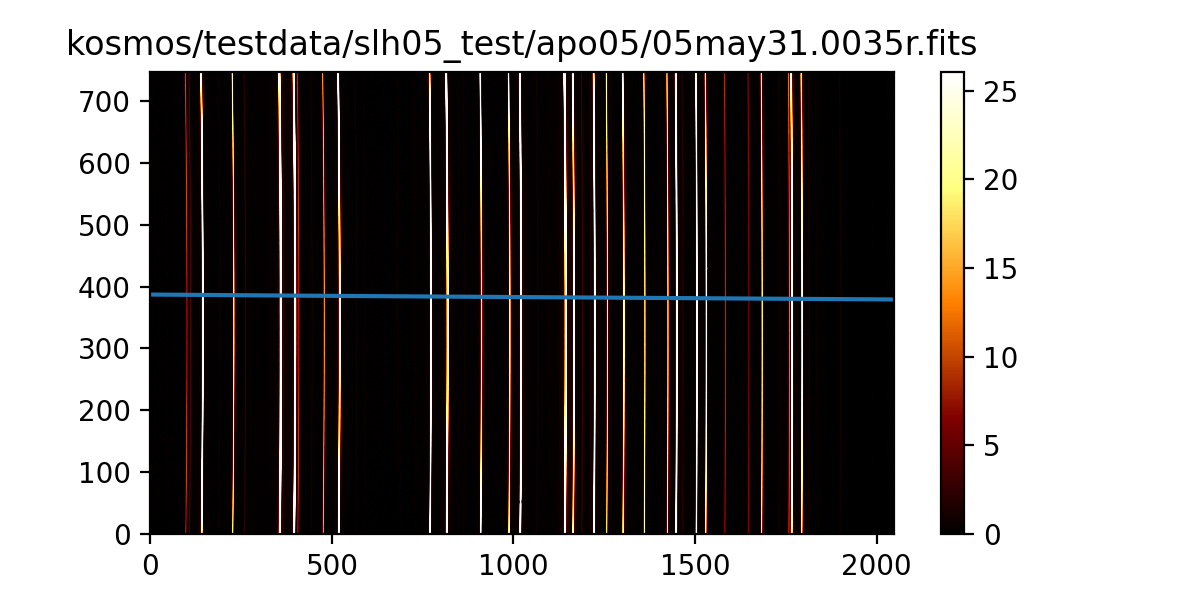

Text(0.5, 1.0, 'kosmos/testdata/slh05_test/apo05/05may31.0035r.fits')

In [17]:
arcfile = dir + '05may31.0035r.fits' # HeNeAr lamp
arcimg = kosmos.proc(arcfile, bias=bias, ilum=ilum, trim=True)

plt.figure(figsize=(6,3))
plt.imshow(arcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace)
plt.clim(np.percentile(arcimg, (5, 97)))
cb = plt.colorbar()
plt.title(arcfile)

<IPython.core.display.Javascript object>


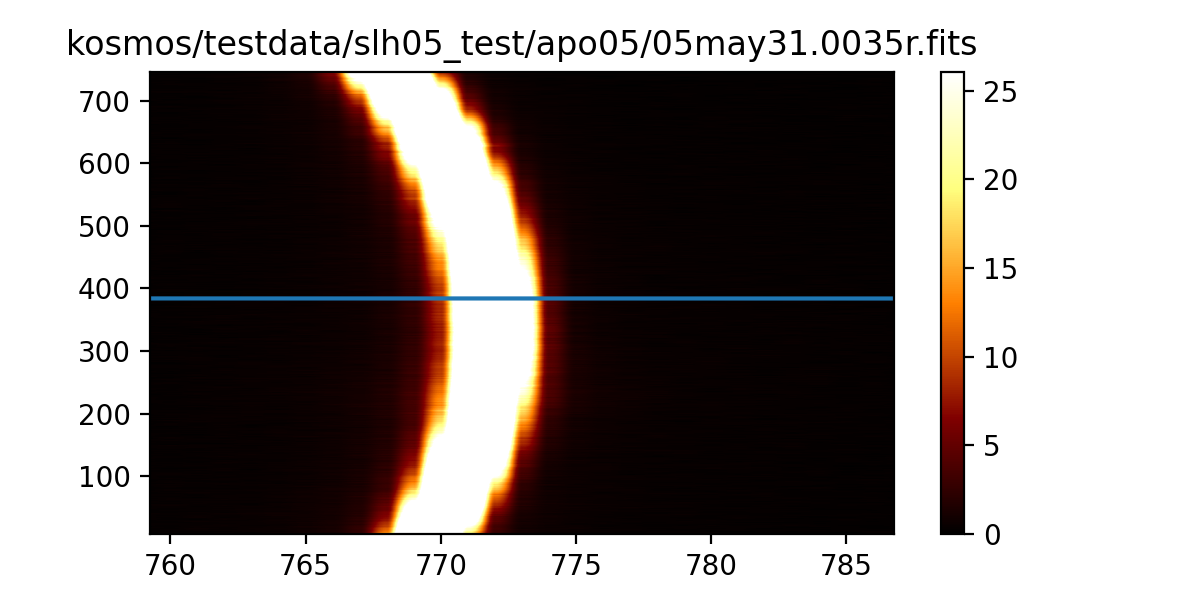

Text(0.5, 1.0, 'kosmos/testdata/slh05_test/apo05/05may31.0035r.fits')

In [22]:
plt.figure(figsize=(6,3))
plt.imshow(arcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace)
plt.clim(np.percentile(arcimg, (5, 97)))
cb = plt.colorbar()
plt.title(arcfile)

/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:297: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


<IPython.core.display.Javascript object>


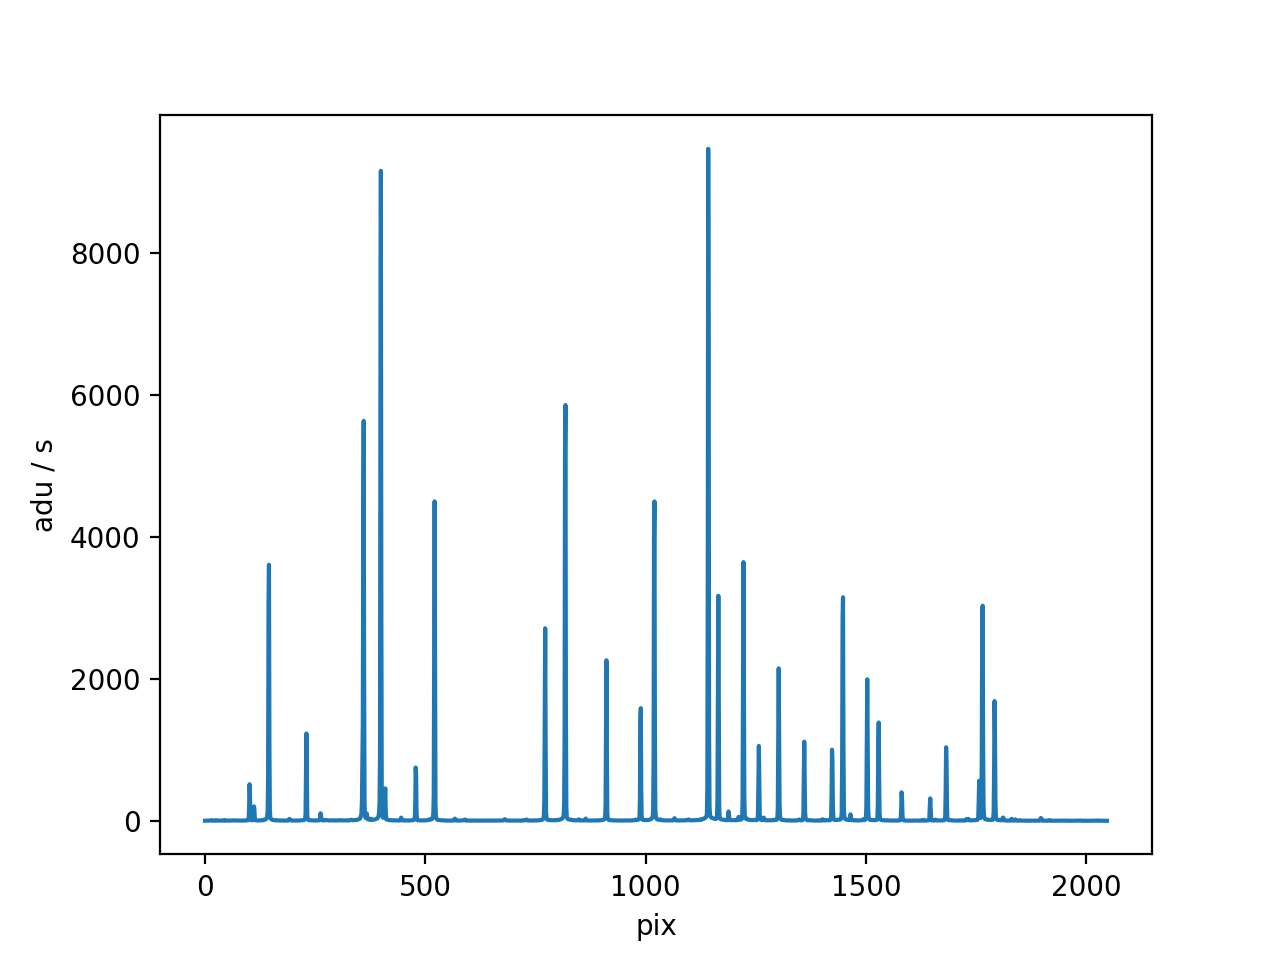

Text(0, 0.5, 'adu / s')

In [18]:
sciarc_ex, sciarc_sky = kosmos.BoxcarExtract(arcimg, sci_trace, apwidth=15, skysep=5, skywidth=5)
calarc_ex, calarc_sky = kosmos.BoxcarExtract(arcimg, cal_trace, apwidth=15, skysep=5, skywidth=5)

plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)
plt.xlabel(sciarc_ex.spectral_axis.unit)
plt.ylabel(sciarc_ex.flux.unit)
# plt.ylim(-10,85)
# wow... so many little features here that can be used by DTW.

<IPython.core.display.Javascript object>


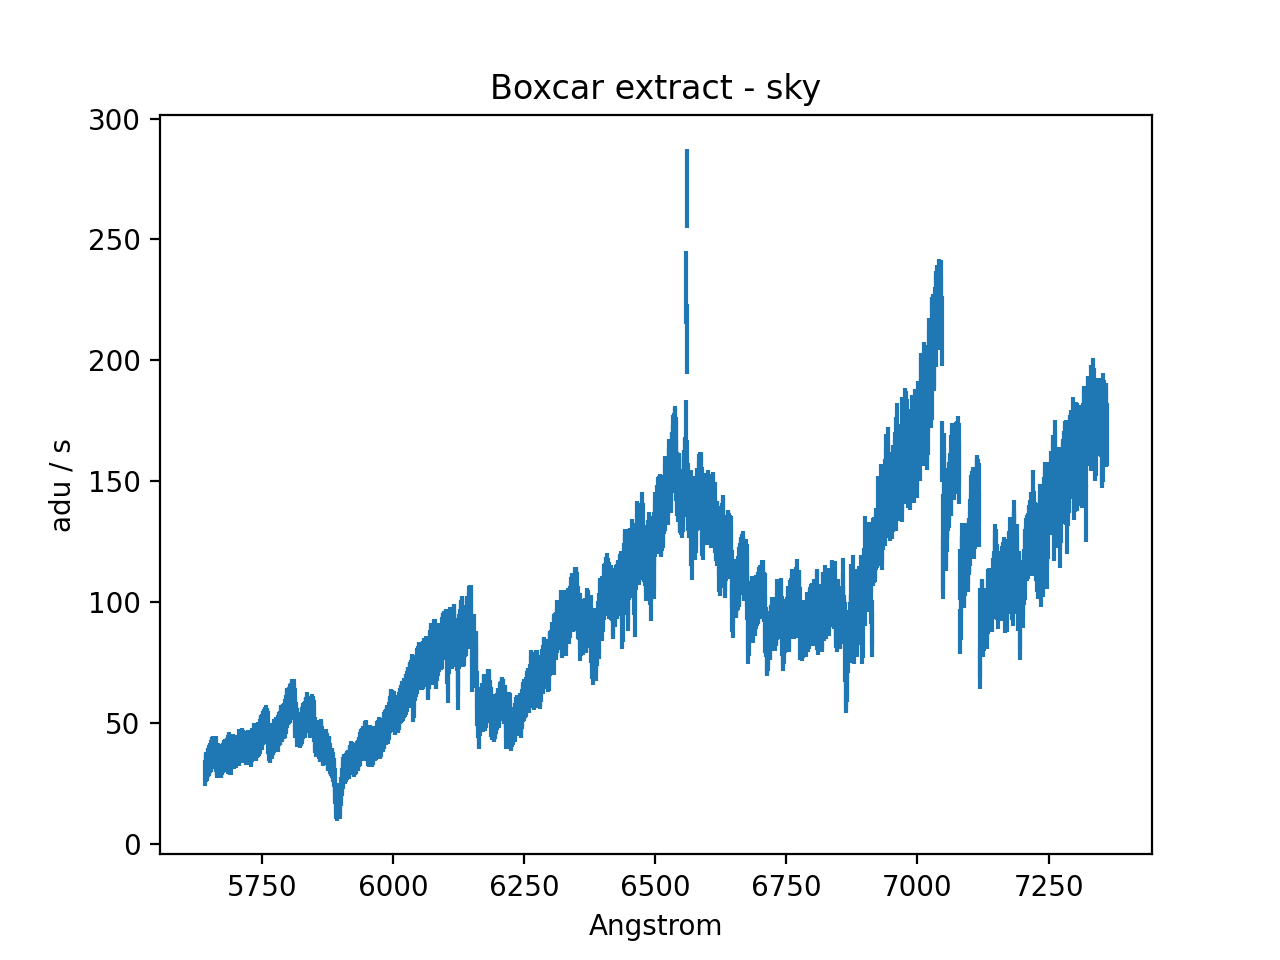

Text(0.5, 1.0, 'Boxcar extract - sky')

In [20]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(sciimg.shape[1]) - sciimg.shape[1]/2)[::-1] * sciimg.header['DISPDW'] + sciimg.header['DISPWC']
wapprox = wapprox * u.angstrom

plt.errorbar(wapprox.value, sci_ex.flux.value - sci_sky.flux.value, 
             yerr=sci_ex.uncertainty.array, linestyle='none')
plt.xlabel(wapprox.unit)
plt.ylabel(sci_ex.flux.unit)
plt.title('Boxcar extract - sky')

# STOP

In [24]:
# CODE WORKS UP TO HERE
# PLEASE IGNORE EVERYTHING BELOW HERE FOR NOW

# need to refactor kosmos identify code to use astropy/specutils type objects & units...
# 2 modes work sorta already: cheap auto match, and the new DTW... need better units stuff
# still need to make sure interactive version works

In [23]:
# a simple table of prominent HeNeAr lines for the instrument in question
apo_henear = pd.read_csv(dir+'apohenear.dat', skiprows=1, names=('wave',))

# use the "nearest" mode, which uses a list of all (?) known line features, and the
# approx wavelength from the header info. Starts in the middle, tries to find nearest 
# peaks to those in the catalog... it works ok-ish for some modes
sci_wave = kosmos.identify(wapprox.value, sciarc_ex.flux.value, identify_mode='nearest', 
                         fit_mode='spline', autotol=5, linewave=apo_henear['wave'].values)

# cal_wave = kosmos.identify(wapprox.value, arc_cal_ex['flux'], identify_mode='nearest', 
#                          fit_mode='spline', autotol=5, linewave=apo_henear['wave'])

TypeError: object of type 'numpy.int64' has no len()

In [108]:
sum((apo_henear['wave'].values >= min(sci_wave)) & (apo_henear['wave'].values <= max(sci_wave)))

21

In [121]:
from kosmos.dtwalign import dtwalign
from specutils import Spectrum1D


In [ ]:
refspec = Spectrum1D(spectral_axis=sci_wave * u.angstrom, flux=sciarc_ex.flux, uncertainty=sciarc_ex.uncertainty)
# use DTW to propgate wavelength solution to another trace
cal_wave_DTW = dtwalign(calarc_ex, refspec, display=True) 


**ISSUE:** `identify` will crash if the input wavelength object has units.

**ISSUE:** `identify` is not returning the wavelength units properly

## 4. Airmass & Flux Calibration

In [105]:
# Select the Std Star reference spectrum from the provided "onedstd" library
stdstar = fc.onedstd('spec50cal/bd284211.dat')

# Select the observatory-specific airmass extinction profile from the provided "extinction" library
Xfile = fc.obs_extinction('apoextinct.dat')

In [106]:
cal_flux = cal_ex['flux'] - cal_ex['skyflux']
cal_spectrum = Spectrum1D(spectral_axis=cal_wave * u.AA, 
                          flux=cal_flux.quantity, 
                          uncertainty=StdDevUncertainty(cal_ex['fluxerr']))

sci_flux = sci_ex['flux'] - sci_ex['skyflux']
sci_spectrum = Spectrum1D(spectral_axis=sci_wave * u.AA, 
                          flux=sci_flux.quantity, 
                          uncertainty=StdDevUncertainty(sci_ex['fluxerr']))

In [107]:
# Get the airmass from the Headers
ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

print(sci_airmass, cal_airmass)

1.0668455410852924 1.052300816491183


In [108]:
# actually apply the airmass corrections
cal_spectrum = fc.airmass_cor(cal_spectrum, cal_airmass, Xfile)

sci_spectrum = fc.airmass_cor(sci_spectrum, sci_airmass, Xfile)

In [110]:
# use a simple linear interpolation for the sensitivity function here
sensfunc = fc.standard_sensfunc(cal_spectrum, stdstar, display=False, mode='linear')

In [115]:
# this is the sensitivity function, which converts the CCD data from
# ADU/S -> erg/s/cm2/A
sensfunc['S'].unit

Unit("erg / (adu Angstrom cm2)")

In [123]:
# Finally, apply the sensfunc (created w/ the standard star) to our observed data
# which has slightly different wavelength units since the trace isn't identical, etc

final_spectrum = fc.apply_sensfunc(sci_spectrum, sensfunc)

final_spectrum.flux.unit

Unit("erg / (Angstrom cm2 s)")

In [140]:
final_spectrum.wavelength.value

array([7365.19653774, 7364.36969376, 7363.54280548, ..., 5641.45942088,
       5640.62972416, 5639.800069  ])

<IPython.core.display.Javascript object>


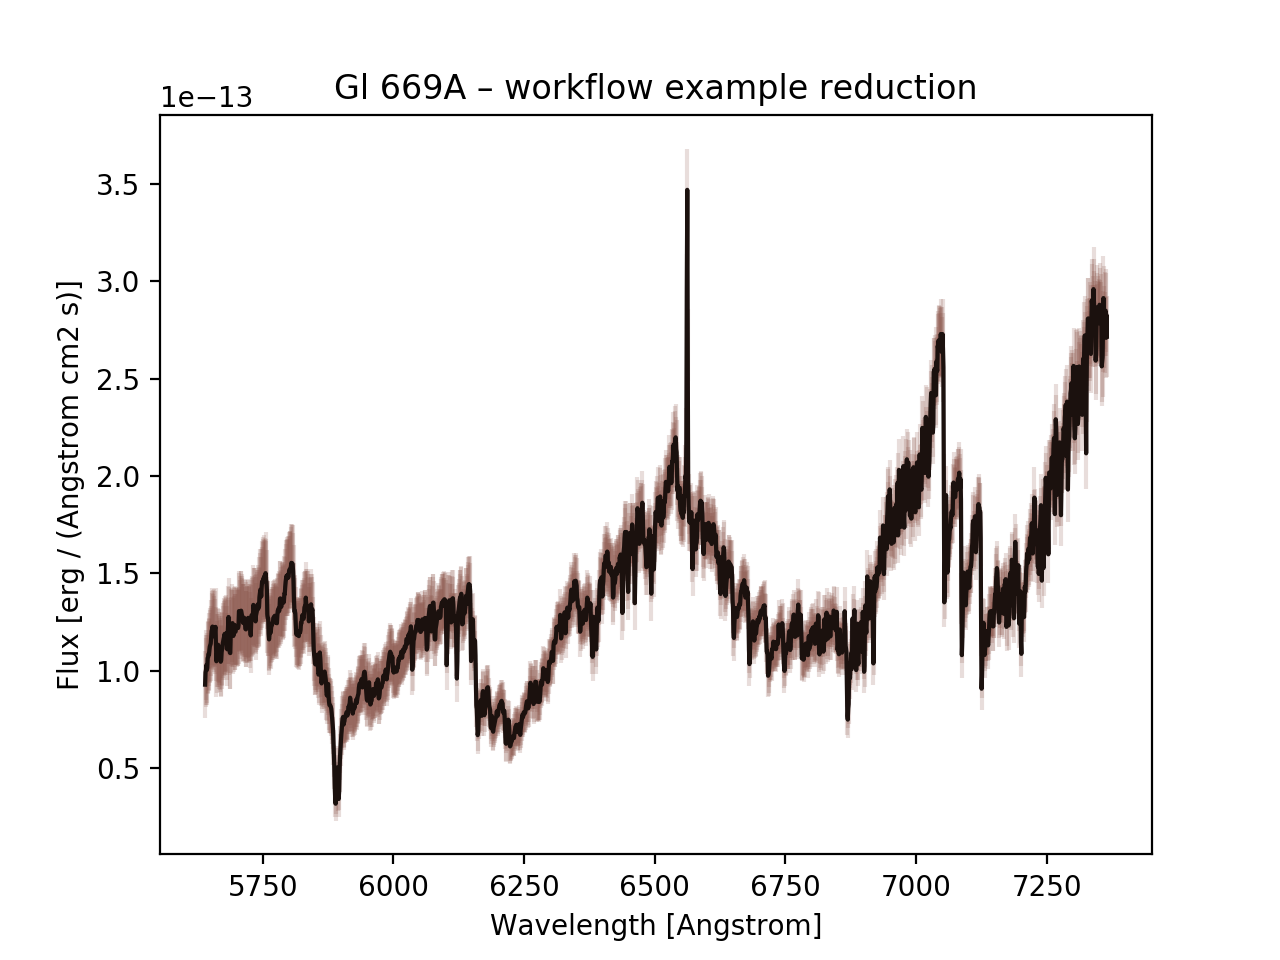

In [151]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

# having to convert the Spectrum1D parameters like this is annoying
# and also inconsistent behavior with the uncertainty
plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
             yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

<IPython.core.display.Javascript object>


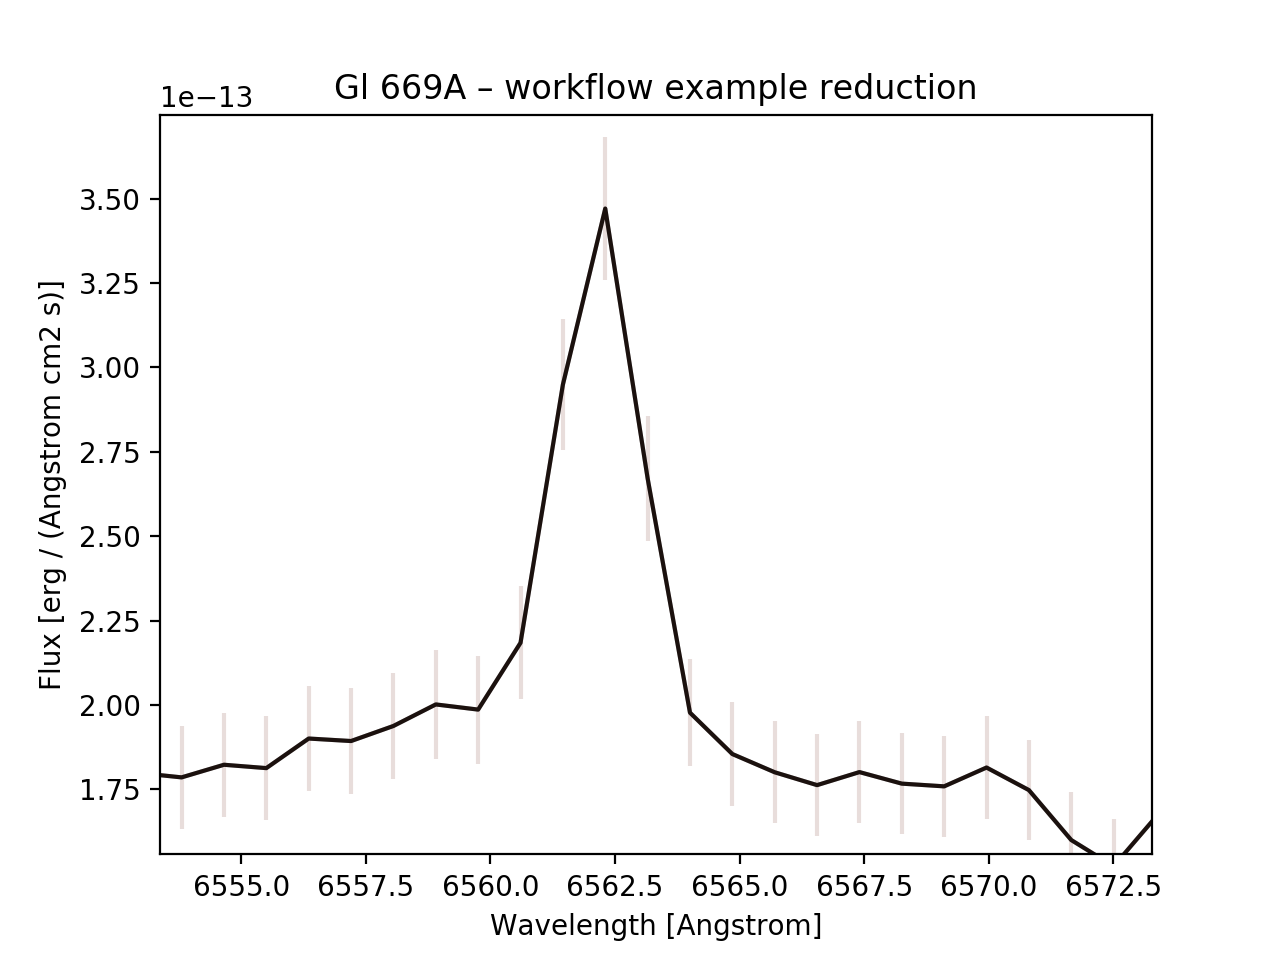

In [152]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
             yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

In [153]:
# things to add in:
# - cosmic rays
# - air2vac conversion

In [156]:
from specutils.utils.wcs_utils import air_to_vac

new_wave = air_to_vac(final_spectrum.wavelength)

<IPython.core.display.Javascript object>


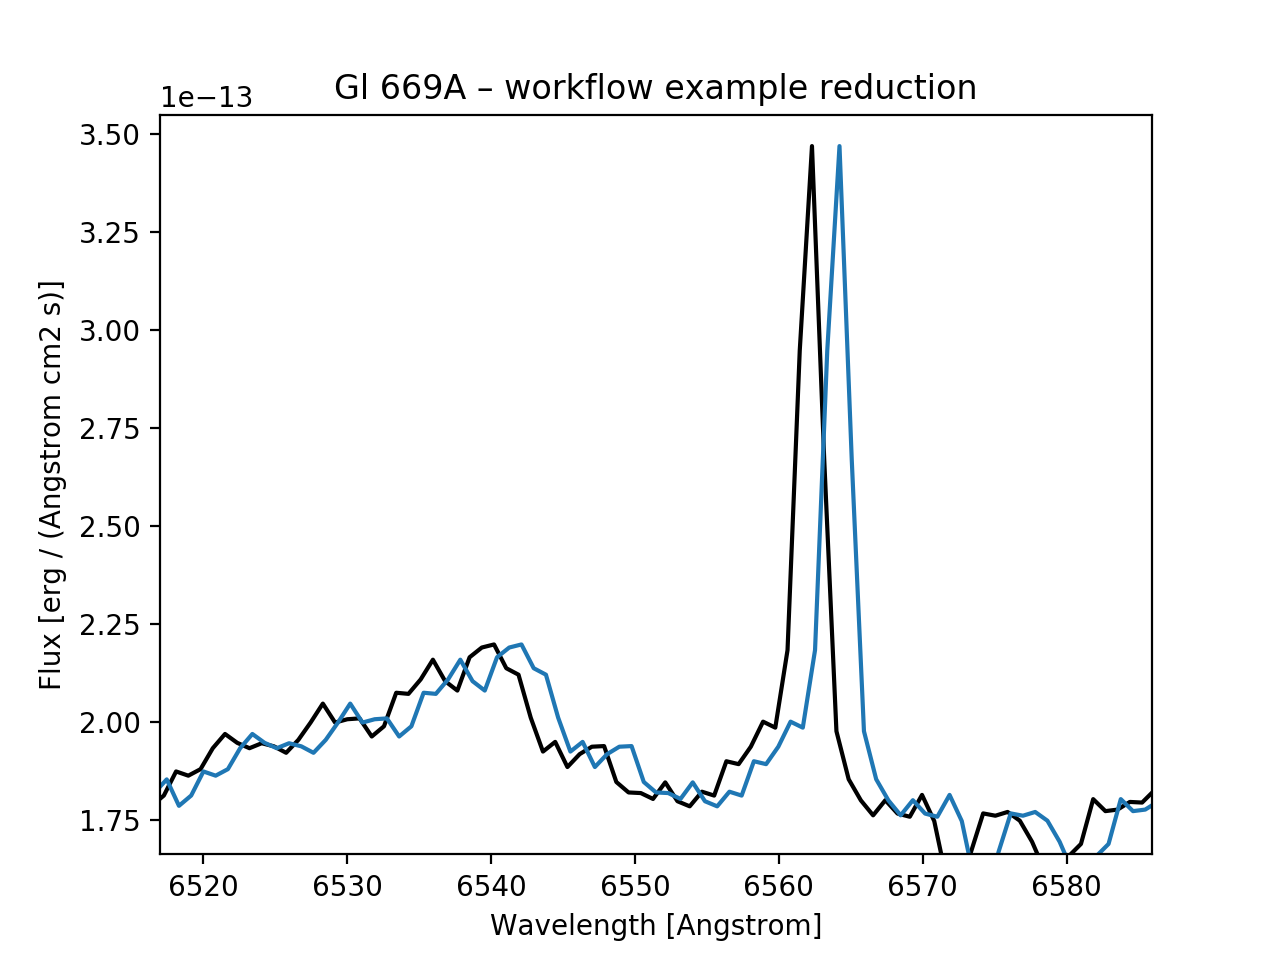

In [160]:
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='K')

plt.plot(new_wave, final_spectrum.flux, c='C0')

# plt.errorbar(new_wave.value, final_spectrum.flux.value, 
#              yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction');

In [161]:
from ccdproc import cosmicray_lacosmic

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<IPython.core.display.Javascript object>


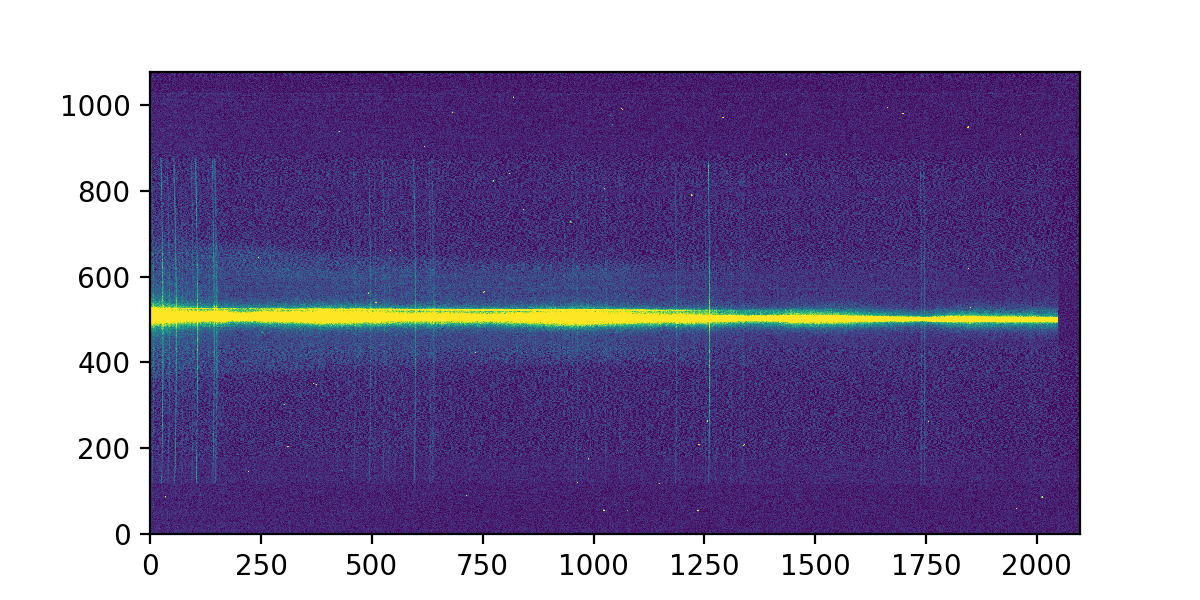

In [201]:
sci = '../../pydis_example/apo05/05may31.0010r.fits' # spectrum of the one target star, Gl 669A
sciimg_raw = CCDData.read(sci, unit=u.adu)

# Cosmic Rays should go HERE, before the basic reduction

plt.figure(figsize=(6,3))
plt.imshow(sciimg_raw, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg_raw, (5, 98)))

In [203]:
%%time
# If desired, this is how to easily do CR cleaning.
# It also will apply the gain, changing the img units from ADU/s to e-/s
# unless `gain_apply` is set to False
sciimg = cosmicray_lacosmic(sciimg_raw, gain=sciimg_raw.header['GAIN'] * u.electron / u.adu, 
                            readnoise=sciimg_raw.header['RDNOISE'] * u.electron, 
                            sigclip=6)


CPU times: user 2.67 s, sys: 150 ms, total: 2.82 s
Wall time: 2.86 s


In [204]:
# BASIC REDUCTION then procedes like normal...
# subtract BIAS, divide FLAT, ExpTime, put in units of ADU/s
sciimg.data = (sciimg.data - BIAS) / (sciimg_raw.header['EXPTIME'])
sciimg.unit = sciimg.unit / u.s

# trim off bias section
sciimg = trim_image(sciimg, fits_section=sciimg_raw.header['DATASEC'])

# Now remove FLAT from illuminated section
sciimg.data[ilum,:] = sciimg.data[ilum,:] / FLAT

INFO:astropy:overwriting Masked Objects's current mask with specified mask.


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [ ]:
# besides cosmic rays, want to also add Telluric Correction examples with TelFit
# https://telfit.readthedocs.io/en/latest/